## Review Work
#### Question: 
Q: Why is TIMB horrible for KNN but does so well for the GP, e.g. on ESM-1b? 

In [1]:
import sys
import os
import numpy as np
import random
from scipy.stats import multivariate_normal, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from gpflow.kernels import SquaredExponential, Linear, Matern52

sys.path.insert(0, '..')
# prepare data
from data import load_dataset
from data.train_test_split import RandomSplitter
from util.preprocess import scale_observations
from algorithms.gp_on_real_space import GPonRealSpace
from algorithms.KNN import KNN

In [ ]:
data = "TIMB"
rep = "esm"

_X, _Y = load_dataset(data, representation=rep)
train_idx, _ , test_idx = RandomSplitter(data).split(_X)

# on first split
X, Y = _X[train_idx[0]], _Y[train_idx[0]]
X_test, Y_test = _X[test_idx[0]], _Y[test_idx[0]]

# scale
mean_y, std_y, scaled_y = scale_observations(Y.copy())

FileNotFoundError: [Errno 2] No such file or directory: '/nfs/home/pmg/projects/protein_regression/data/files/timb_seq_reps_n_phyla.pkl'

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


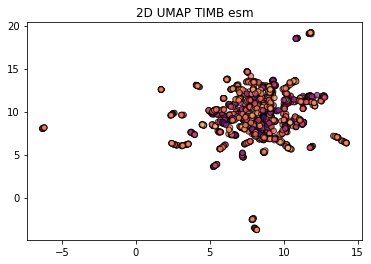

In [3]:
from make_plot_representations import plot_reduced_representations

plot_reduced_representations(data, rep)

### Fitted KNN

In [4]:
method_knn = KNN(optimize=True)
method_knn.train(X, scaled_y)

Score: 0.8465005455434795
Parameters: k=432


In [5]:
_mu_knn_train, _var_knn_train = method_knn.predict_f(X)

y_pred_knn_train = _mu_knn_train*std_y + mean_y
var_knn_train = _var_knn_train*std_y

_mu_knn_test, _var_knn_test = method_knn.predict_f(X_test)

y_pred_knn_test = _mu_knn_test*std_y + mean_y
var_knn_test = _var_knn_test * std_y

### Fitted GP

In [6]:
# GP for TIMB on RandomSplitter, fitted values: l_var = 0.23, len=0.2
# NOTE: we take the already optimized parameters here
method = GPonRealSpace(kernel_factory=lambda: Matern52(variance=0.23, lengthscales=0.2), optimize=False)
method.train(X, scaled_y)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-14 10:40:06.425737: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-14 10:40:06.425875: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
_mu, _var = method.predict(X) # NOTE: include data-noise for KNN comparison, for only model noise use predict_f

y_pred = _mu*std_y + mean_y
var = _var*std_y

In [8]:
_mu_test, _var_test = method.predict(X_test)

y_pred_test = _mu_test*std_y + mean_y
var_test = _var_test*std_y

In [9]:
_mu.shape, _var.shape

(TensorShape([1367, 1]), TensorShape([1367, 1]))

/Users/rcml/miniforge3/envs/env_tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rcml/miniforge3/envs/env_tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rcml/miniforge3/envs/env_tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error o

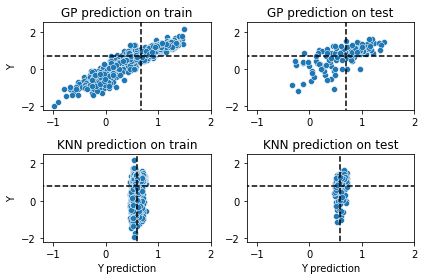

In [10]:
y_lim = (-2.2, 2.5)
x_lim = (-1.2, 2.)
fig, ax = plt.subplots(2,2)
sns.scatterplot(y_pred.numpy().flatten(), Y.flatten(), ax=ax[0,0])
sns.scatterplot(y_pred_test.numpy().flatten(), Y_test.flatten(), ax=ax[0,1])
sns.scatterplot(y_pred_knn_train.flatten(), Y.flatten(), ax=ax[1,0])
sns.scatterplot(y_pred_knn_test.flatten(), Y_test.flatten(), ax=ax[1,1])
ax[0,0].set_title("GP prediction on train")
ax[0,0].set_ylabel("Y")
ax[1,0].set_xlabel("Y prediction")
ax[0,1].set_title("GP prediction on test")
ax[1,0].set_title("KNN prediction on train")
ax[1,0].set_ylabel("Y")
ax[1,1].set_xlabel("Y prediction")
ax[1,1].set_title("KNN prediction on test")
ax[0,0].set_ylim(y_lim)
ax[1,0].set_ylim(y_lim)
ax[0,1].set_ylim(y_lim)
ax[1,1].set_ylim(y_lim)
ax[0,0].set_xlim(x_lim)
ax[1,0].set_xlim(x_lim)
ax[0,1].set_xlim(x_lim)
ax[1,1].set_xlim(x_lim)
ax[0,0].axvline(np.mean(y_pred.numpy().flatten()), y_lim[0], y_lim[1], c="k", linestyle="--")
ax[0,1].axvline(np.mean(y_pred_test.numpy().flatten()), y_lim[0], y_lim[1], c="k", linestyle="--")
ax[1,0].axvline(np.mean(y_pred_knn_train.flatten()), y_lim[0], y_lim[1], c="k", linestyle="--")
ax[1,1].axvline(np.mean(y_pred_knn_test.flatten()), y_lim[0], y_lim[1], c="k", linestyle="--")
ax[0,0].axhline(np.mean(Y.flatten()), x_lim[0], x_lim[1], c="k", linestyle="--")
ax[0,1].axhline(np.mean(Y.flatten()), x_lim[0], x_lim[1], c="k", linestyle="--")
ax[1,0].axhline(np.mean(Y_test.flatten()), x_lim[0], x_lim[1], c="k", linestyle="--")
ax[1,1].axhline(np.mean(Y_test.flatten()), x_lim[0], x_lim[1], c="k", linestyle="--")
plt.tight_layout()
plt.show()

Text(0.5, 0.98, 'Predictive variances (test) \n (GP data noise included)')

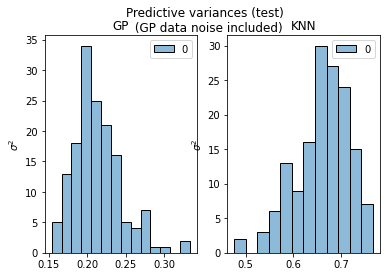

In [11]:
fig, ax = plt.subplots(1, 2)
sns.histplot(var_test, ax=ax[0])
sns.histplot(var_knn_test, ax=ax[1])
ax[0].set_title("GP")
ax[1].set_title("KNN")
ax[0].set_ylabel(r"$\sigma^2$")
ax[1].set_ylabel(r"$\sigma^2$")
plt.suptitle("Predictive variances (test) \n (GP data noise included)")

In [12]:
mvn_train = multivariate_normal(mean=y_pred.numpy().flatten(), cov=var.numpy().flatten())
mvn_test = multivariate_normal(mean=y_pred_test.numpy().flatten(), cov=var_test.numpy().flatten())
# draw from training

In [13]:
mvn_knn_train = multivariate_normal(mean=y_pred_knn_train.flatten(), cov=var_knn_train.flatten())
mvn_knn_test = multivariate_normal(mean=y_pred_knn_test.flatten(), cov=var_knn_test.flatten())

In [18]:
d_train_samples = mvn_train.rvs(size=5)
d_test_samples = mvn_test.rvs(size=5)
d_train_knn_samples = mvn_knn_train.rvs(size=5)
d_test_knn_samples = mvn_knn_test.rvs(size=5)

Text(0.5, 0.98, 'Distribution Samples')

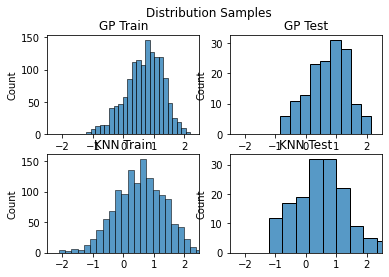

In [17]:
xlim=(-2.5, 2.5)
fig, ax = plt.subplots(2, 2)
sns.histplot(d_train_samples.flatten(), ax=ax[0,0])
sns.histplot(d_test_samples.flatten(), ax=ax[0,1])
sns.histplot(d_train_knn_samples.flatten(), ax=ax[1,0])
sns.histplot(d_test_knn_samples.flatten(), ax=ax[1,1])
ax[0,0].set_title("GP Train")
ax[0,0].set_xlim(xlim)
ax[0,1].set_xlim(xlim)
ax[1,0].set_xlim(xlim)
ax[1,1].set_xlim(xlim)
ax[0,1].set_title("GP Test")
ax[1,0].set_title("KNN Train")
ax[1,1].set_title("KNN Test")
plt.suptitle("Distribution Samples")

## Section Predictive Uncertainties
### and Extrapolation

Q: Can we add multiple mutations at random and rank by predictive uncertainties?

In [2]:
dataset = "1FQG"
N_mutants = 200
N_splits = 3
REPRESENTATION = "one_hot"

In [3]:
from data.load_dataset import load_one_hot
from data import load_dataset, get_alphabet
from util import numpy_one_hot_2dmat
from algorithm_factories import ALGORITHM_REGISTRY
from algorithm_factories import KNNFactory, UncertainRFFactory, GPMaternFactory, GPLinearFactory
import seaborn as sns
import pandas as pd
import random

X_seq, _ = load_one_hot(dataset) # obtain original sequence

X_mutated = {}
# add mutations to X
for m_count in [2, 3, 4]:
    X_mutated[m_count] = []
    for _ in range(N_mutants): # make 1000 substitutions
        _X = X_seq[0].copy() # copy WT for mutation
        pos = random.sample(range(X_seq.shape[1]), m_count) # select positions, no duplicates
        aa = np.random.randint(0, 20, size=m_count) # select AA for substitutions, w/ duplicates
        while any([a==x for a,x in zip(aa, _X[pos])]):
            aa = np.random.randint(0, len(get_alphabet(dataset)), size=m_count) # redraw if same AA
        _X[pos] = aa
        assert sum(x!=y for x, y in zip(_X, X_seq[0])) == m_count # test that dist to WT is mutation count
        # one-hot encode mutated X
        X_mutated[m_count].append(_X)
    # one-hot encode and normalize by seq length
    X_mutated[m_count] = numpy_one_hot_2dmat(np.vstack(X_mutated[m_count]), max=len(get_alphabet(dataset)))

In [4]:
# Training data
X, Y = load_dataset(dataset, representation=REPRESENTATION)
# Randomsplitting
train_indices, _, test_indices = RandomSplitter(dataset).split(X)

results_dict = {}
# for method_factory in [UncertainRFFactory, KNNFactory, GPMaternFactory, GPLinearFactory, ]:
for method_factory in [KNNFactory, GPMaternFactory, GPLinearFactory, UncertainRFFactory]:
    method = method_factory("one_hot", alphabet=get_alphabet(dataset))
    print(f"Method: {method.get_name()}")
    results_dict[method.get_name()] = {}
    for split in range(N_splits):
        print(f"split={split}")
        X_train = X[train_indices[split], :]
        Y_train = Y[train_indices[split], :]
        X_test = X[test_indices[split], :]
        Y_test = Y[test_indices[split]]
        # STANDARDIZE OBSERVATIONS ON TRAIN
        mean_y, std_y, scaled_y = scale_observations(Y_train.copy())
        # SET PRIORS IF GP
        if "GP" in method.get_name() and X_train.shape[0] > 1: # set initial parameters based on distance in space if using full latent space
            init_len = np.max(np.abs(np.subtract(X_train[0], X_train[1])))
            eps = 0.001
            method.init_length = init_len if init_len > 0.0 else init_len+eps # if reduced on lower dim this value is too small
        # TRAIN MODEL:
        method.train(X_train, scaled_y)
        # PREDICT:
        _mu, _unc = method.predict_f(X_test)
        # undo scaling
        mu = _mu*std_y + mean_y
        unc = _unc*std_y
        assert(mu.shape[1] == 1 == unc.shape[1])
        assert(mu.shape[0] == unc.shape[0] == len(test_indices[split]))
        # record mean and median smse and nll and spearman correlation
        assert mu.shape == Y_test.shape, "shape mismatch "+str(mu.shape)+' '+str(Y_test.flatten().shape)
        # COMPUTE RESULT METRICS
        baseline = np.mean(np.square(Y_test - np.repeat(mean_y, len(Y_test)).reshape(-1,1)))
        err2 = np.square(Y_test - mu)
        mse = np.mean(err2)/baseline
        r = spearmanr(Y_test, mu)[0]  # we do not care about the p-value
        n = X_train.shape[0]
        print(f"Split={split}: r={r}, NMSE={mse}")

        # Test ranking multivariates
        mv_predictions = {}
        for m_count in X_mutated.keys():
            _, _unc = method.predict(X_mutated[m_count])
            unc = _unc*std_y
            mv_predictions[m_count] = unc
        all_mv_predictive_variances = np.concatenate([val for val in mv_predictions.values()]).flatten()
        results_dict[method.get_name()][split] = mv_predictions

Method: KNN
split=0
Score: 0.9166918853733486
Parameters: k=1295
Split=0: r=0.2895504310912796, NMSE=0.9847896745442618
split=1
Score: 0.9158740220082136
Parameters: k=1072
Split=1: r=0.3133132238064156, NMSE=0.9720086324753012
split=2
Score: 0.9163037838472917
Parameters: k=1364
Split=2: r=0.17728986526963128, NMSE=1.0001712222548884
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Method: GPmatern52
split=0


2023-05-27 11:34:47.976150: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-27 11:34:47.977016: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-05-27 11:34:48.377379: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-05-27 11:34:49.084096: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-27 11:34:49.085009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Split=0: r=0.7548622779128203, NMSE=0.432837744574636
split=1


2023-05-27 11:39:03.747378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Split=1: r=0.7562687524582924, NMSE=0.43871617135179103
split=2


2023-05-27 11:43:16.450658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Split=2: r=0.7303266940342773, NMSE=0.4434632296168605
Method: GPlinear
split=0


2023-05-27 11:47:30.481347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Split=0: r=0.7551314132449715, NMSE=0.9999996365476451
split=1


2023-05-27 11:53:35.331805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Split=1: r=0.750755031100727, NMSE=0.9999996338995519
split=2


2023-05-27 11:59:42.180201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Split=2: r=0.7319760379408232, NMSE=0.9999996449874929
Method: uncertainRF
split=0
Score: 1.0543337174988843
Parameters: N=2
2
Split=0: r=0.7116529102483042, NMSE=0.6436785899599776
2
2
2
split=1
Score: 1.0470931237687147
Parameters: N=2
2
Split=1: r=0.72394949770214, NMSE=0.6150263603668048
2
2
2
split=2
Score: 1.0618834252588885
Parameters: N=1151
1151
Split=2: r=0.7313755988470966, NMSE=0.5272268825570215
1151
1151
1151


In [10]:
with open("../results/cache/results_dict_1FQG_OH.pkl", "wb") as outfile:
    pickle.dump(results_dict, outfile)

In [5]:
regressors = []
dfs = []
for regressor, d in results_dict.items():
    regressors.append(regressor)
    _d = {s: {m: np.array(arr) for m, arr in split_results.items()} for s, split_results in d.items()}
    dfs.append(pd.DataFrame.from_dict(_d, orient="index"))

complete_df = pd.concat(dfs, keys=regressors)
complete_df = pd.melt(complete_df.explode([2,3,4]).reset_index().rename(columns={"level_0": "regressor", "level_1": "split"}), id_vars=["regressor", "split"], value_vars=[2,3,4])
complete_df = complete_df.rename(columns={"variable": "n_mutations"}).explode("value")
complete_df

,regressor,split,n_mutations,value
0,KNN,0,2,1.083792
1,KNN,0,2,1.069383
2,KNN,0,2,1.080218
3,KNN,0,2,1.065798
4,KNN,0,2,1.076784
...,...,...,...,...
7195,uncertainRF,2,4,0.359477
7196,uncertainRF,2,4,0.601277
7197,uncertainRF,2,4,0.50226
7198,uncertainRF,2,4,0.402784


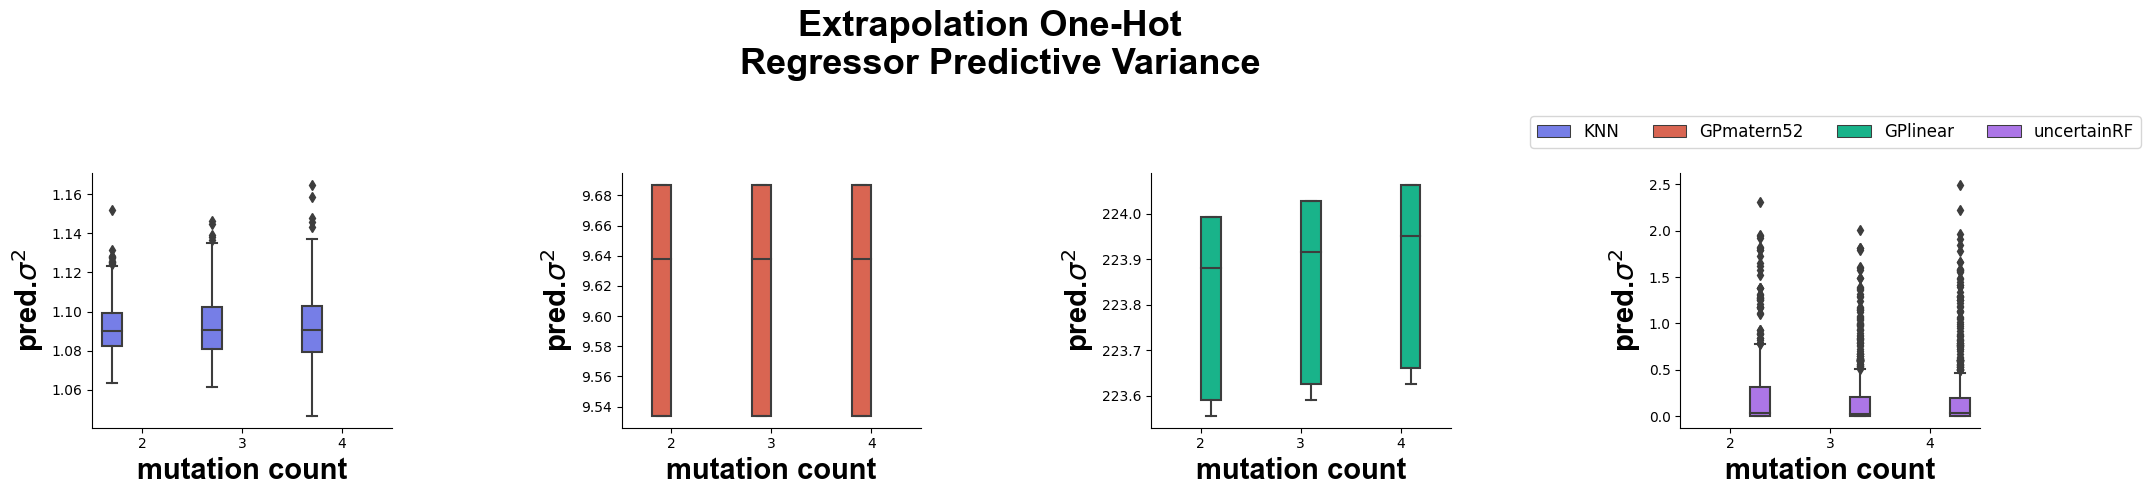

In [19]:
complete_df = complete_df.sort_index(axis=1)

g = sns.catplot(data=complete_df, kind="box", col="regressor", y="value", x="n_mutations", hue="regressor",
#col_order=['KNN', 'GPlinear', 'GPmatern52'], 
sharey=False, margin_titles=False, palette=sns.color_palette(["#636EFA", "#EF553B", "#00CC96", "#AB63FA", "#FFA15A", "#19D3F3", "#FF6692", "#B6E880", "#FF97FF", "#FECB52"]))
for ax in g.axes.flat:
    ax.xaxis.set_label_text("mutation count", **{'family': 'Arial', 'fontsize': 21, "weight": 'bold'})
    ax.yaxis.set_label_text(r"pred.$\sigma^2$", **{'family': 'Arial', 'fontsize': 21, "weight": 'bold'})
    ax.set_title("")
handles, labels = g.axes[-1, -1].get_legend_handles_labels()
plt.legend(handles, labels, loc=(-0.5,1.1) , ncol=4, prop={'size': 12}) #bbox_to_anchor=(-0.6,1.2)
plt.suptitle("Extrapolation One-Hot \n Regressor Predictive Variance", **{'family': 'Arial', 'fontsize': 26, "weight": 'bold'})
plt.tight_layout()
plt.savefig(f"../results/figures/uncertainties/extrapolation_task_{REPRESENTATION}.png", bbox_inches='tight')
plt.show()

In [7]:
### LOAD ESM PRED.VAR. RESULTS
import pickle

with open("../results/cache/results_dict_1FQG.pkl", "rb") as infile:
    x = pickle.load(infile)

_regressors = []
_dfs = []
for regressor, d in x.items():
    _regressors.append(regressor)
    _d = {s: {m: np.array(arr) for m, arr in split_results.items()} for s, split_results in d.items()}
    _dfs.append(pd.DataFrame.from_dict(_d, orient="index"))

esm_complete_df = pd.concat(_dfs, keys=_regressors)
esm_complete_df = pd.melt(esm_complete_df.explode([2,3,4]).reset_index().rename(columns={"level_0": "regressor", "level_1": "split"}), id_vars=["regressor", "split"], value_vars=[2,3,4])
esm_complete_df = esm_complete_df.rename(columns={"variable": "n_mutations"}).explode("value")
esm_complete_df

,regressor,split,n_mutations,value
0,uncertainRF,0,2,0.957881
1,uncertainRF,0,2,0.988777
2,uncertainRF,0,2,0.948592
3,uncertainRF,0,2,0.74608
4,uncertainRF,0,2,0.998278
...,...,...,...,...
7195,GPlinear,2,4,0.243515
7196,GPlinear,2,4,0.242145
7197,GPlinear,2,4,0.242849
7198,GPlinear,2,4,0.242502


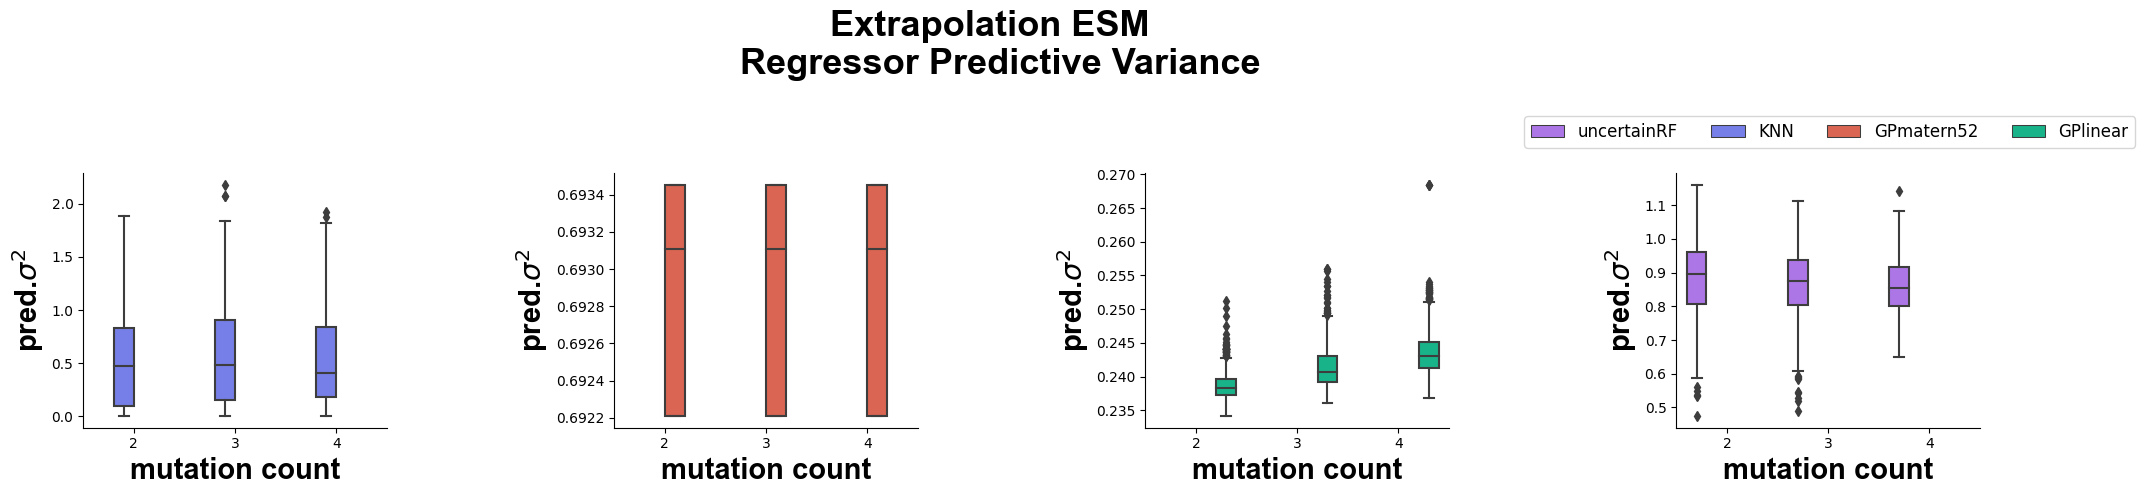

In [21]:
esm_complete_df = esm_complete_df.sort_index(axis=1)

g = sns.catplot(data=esm_complete_df, kind="box", col="regressor", y="value", x="n_mutations", hue="regressor", col_order=['KNN', 'GPmatern52', 'GPlinear',  'uncertainRF'],
sharey=False, margin_titles=False, palette={"KNN": "#636EFA", "GPmatern52": "#EF553B", "GPlinear":  "#00CC96", "uncertainRF": "#AB63FA"})
for ax in g.axes.flat:
    ax.xaxis.set_label_text("mutation count", **{'family': 'Arial', 'fontsize': 21, "weight": 'bold'})
    ax.yaxis.set_label_text(r"pred.$\sigma^2$", **{'family': 'Arial', 'fontsize': 21, "weight": 'bold'})
    ax.set_title("")
handles, labels = g.axes[-1, -1].get_legend_handles_labels()
plt.legend(handles, labels, loc=(-0.5,1.1) , ncol=4, prop={'size': 12}) #bbox_to_anchor=(-0.6,1.2)
plt.suptitle("Extrapolation ESM \n Regressor Predictive Variance", **{'family': 'Arial', 'fontsize': 26, "weight": 'bold'})
plt.tight_layout()
plt.savefig(f"../results/figures/uncertainties/extrapolation_task_ESM.png", bbox_inches='tight')
plt.show()